# Importing Dependencies

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import DataLoader

from torchmetrics import JaccardIndex


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
import torch.cuda as cuda

In [3]:
import matplotlib.pyplot as plt

In [4]:
import cv2 as cv

In [5]:
import torch.nn.functional as F
import torchvision.transforms.functional as TF

In [6]:
from torch.utils.data import Dataset

import os
import numpy as np
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [7]:
from sklearn.model_selection import train_test_split

# Splitting Dataset

In [8]:

def load_data(img_dir, mask_dir):
    image_list=[os.path.join(img_dir, x) for x in sorted(os.listdir(img_dir))]
    mask_list=[os.path.join(mask_dir, x) for x in sorted(os.listdir(mask_dir))]
    X, Y=image_list,mask_list
    X_train, X_test, Y_train, Y_test=train_test_split(X,Y,test_size=0.25, random_state=42)
    return X_train, X_test, Y_train, Y_test

In [9]:
ren="/kaggle/input/artificial-lunar-rocky-landscape-dataset/images/render/"
clean="/kaggle/input/artificial-lunar-rocky-landscape-dataset/images/clean/"
X_train, X_test, Y_train, Y_test=load_data(ren,clean)
print(type(X_train))
print(len(X_train))
print(len(X_test))

<class 'list'>
7324
2442


# Image Mask

(256, 256)
[0 1 2 3]


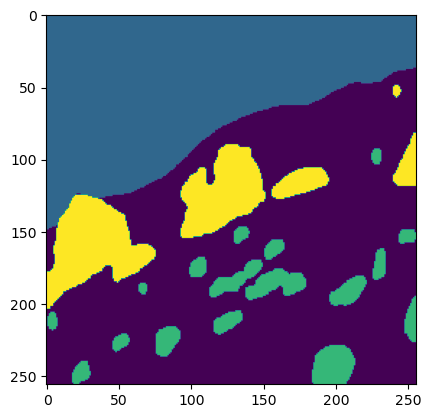

In [10]:

randnum = np.random.randint(7000)
# imgx = cv.cvtColor(cv.imread(Y_train[randnum]),cv.COLOR_RGB2GRAY)
imgx = cv.cvtColor(cv.imread('/kaggle/input/artificial-lunar-rocky-landscape-dataset/images/clean/clean2664.png'),cv.COLOR_RGB2GRAY)
imgx=cv.resize(imgx,(256,256),interpolation=cv.INTER_NEAREST)
mask = np.array(imgx)
# mask = np.reshape(mask,(256,256,4))
mask[mask==29]=1
mask[mask==76]=3
mask[mask==150]=2
print(mask.shape)
plt.imshow(mask)

print(np.unique(mask))

In [11]:
from torchvision import transforms
transform=transforms.Compose([transforms.ToTensor()])

## DATASET CLASS

In [12]:
class LunarDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):

        self.img_ren = img_dir                                #with load data func
        self.img_clean = mask_dir
        self.transform=transform
    def __len__(self):
        return len(self.img_ren)
    
    def __getitem__(self, index):
        

        img_path=self.img_ren[index]
#         print(img_path)
        
        mask_path=self.img_clean[index]
 
        img1=cv.imread(img_path)
        
        img2=cv.imread(mask_path)
        
        img1=cv.resize(img1,(300,300),interpolation =cv.INTER_NEAREST)
        img2=cv.resize(img2,(300,300),interpolation =cv.INTER_NEAREST)
       

        #CONVERSION OF INPUT IMAGE FROM RGB TO BGR
          
        image=np.array(cv.cvtColor(img1,cv.COLOR_RGB2BGR), dtype=np.float32)
        
        mask=np.array(cv.cvtColor(img2,cv.COLOR_RGB2GRAY), dtype=np.int32)
        image=image/255.0  
        

        
#         mask=mask/255  
        
        if self.transform:
            image=self.transform(image)

        mask[mask==29]=1
        mask[mask==76]=3
        mask[mask==150]=2

        mask = torch.LongTensor(mask)

        return image, mask

# Class Inference

out1 [0 1 2 3]
<class 'torch.Tensor'>


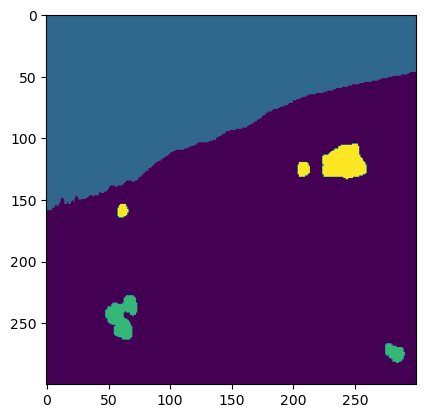

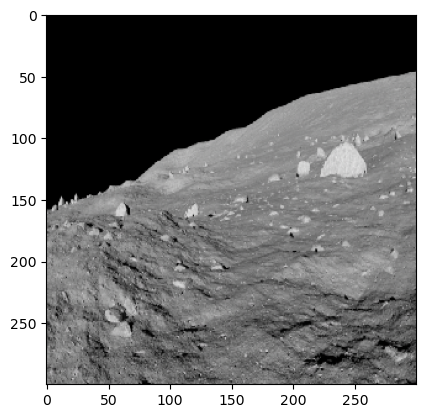

In [13]:

b=LunarDataset(X_train, Y_train, transform)

lo,om=b[10]

print("out1",np.unique(om))
plt.figure()
plt.imshow(om)


sd=torch.transpose(lo,0,1)
# print(sd.shape)
jk=torch.transpose(sd,1,2)
# print(jk.shape)
plt.figure()
plt.imshow(jk)
print(type(jk))


## LOAD FUNCTION

In [14]:
def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["model_state_dict"])    

## Data Loader

In [15]:
def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    num_workers=0,
    pin_memory=False,
):
    train_ds = LunarDataset(
        img_dir=train_dir,
        mask_dir=train_maskdir,
        transform=transform,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )

    val_ds = LunarDataset(
        img_dir=val_dir,
        mask_dir=val_maskdir,
        transform=transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return train_loader, val_loader
# print(len(train_loader))
# print(len(train_loader.dataset))


## BEST MODEL SAVER FUNCTION

In [16]:
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(self, best_valid_loss=float('-inf')):
            self.best_valid_loss = best_valid_loss
        
    def __call__(self, current_valid_loss, epoch, model, optimizer, criterion):
        if current_valid_loss > self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
#             print(f"\nBest validation loss: {self.best_valid_loss}")
#             print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                'scheduler': scheduler,
                }, 'best_model.pth')

## MODEL ARCHITECTURE

In [17]:
#The double convolution operation which occurs twice 

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv=nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1,1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
#         nn.Dropout(0.5),

        nn.Conv2d(out_channels, out_channels, 3, 1,1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
#         nn.Dropout(0.5)
        )
    
        
    def forward(self, x):
        
        return self.conv(x)
    
 #Dropout 0.25 -> 0.50   

In [18]:
class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64,128,256,512]):    #Features in the lists are from the arch
        super(UNET, self).__init__()
        self.ups=nn.ModuleList()     #creating modulelists to store operations output
        self.downs=nn.ModuleList()
        self.pool=nn.MaxPool2d(kernel_size=2, stride=2)   #preforms maxpooling to down sample the image size and extract features
        
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))   #assigining features to input channels after DoubleConv operation
            in_channels=feature                           #going downside in the architecture
                                                        
            
        for feature in reversed(features):               #reversing the features list for moving upward in architecture
            self.ups.append(nn.ConvTranspose2d(          #upsampling the image
                feature*2, feature, kernel_size=2, stride=2))   
            self.ups.append(DoubleConv(feature*2, feature))     #after upsampling performing DoubleConv operation 
            
        self.bottleneck=DoubleConv(features[-1],features[-1]*2)   #base layer creation
        self.final_conv=nn.Conv2d(features[0],out_channels, kernel_size=1)   #the Output Conv operartion

    def forward(self, x):           #the execution part of unet
        skip_connections=[]         #list to store skip_connections
        for down in self.downs:     #going downside in the architecture
            x=down(x)              
            skip_connections.append(x)     #store connections 
            x=self.pool(x)                 #maxpooling 
        x=self.bottleneck(x)               #base layer of unet
         
        skip_connections=skip_connections[::-1]     #reversing the skip connection list to move upwards
        
        for ind in range(0, len(self.ups), 2):
            x=self.ups[ind](x)
            skip_connection=skip_connections[ind//2]      #traversing the up module list to move upwards and storing connections
            
            if x.shape!=skip_connection.shape:
                x=TF.resize(x,size=skip_connection.shape[2:])   #resizing shapes for good divisibility operation
                
                
            concat_skip=torch.cat((skip_connection,x),dim=1)   #concating the skip connections to the up part of unet
            x=self.ups[ind+1](concat_skip)                     
        return self.final_conv(x)                              #returning the final conv output
    
    

## MODEL SUMMARY

In [20]:
# conda install -c conda-forge torchinfo
from torchvision import models
from torchinfo import summary
a  = UNET(3,4)
summary(a,input_size=(20,3,256,256))

Layer (type:depth-idx)                   Output Shape              Param #
UNET                                     [20, 4, 256, 256]         --
├─ModuleList: 1-7                        --                        (recursive)
│    └─DoubleConv: 2-1                   [20, 64, 256, 256]        --
│    │    └─Sequential: 3-1              [20, 64, 256, 256]        38,848
├─MaxPool2d: 1-2                         [20, 64, 128, 128]        --
├─ModuleList: 1-7                        --                        (recursive)
│    └─DoubleConv: 2-2                   [20, 128, 128, 128]       --
│    │    └─Sequential: 3-2              [20, 128, 128, 128]       221,696
├─MaxPool2d: 1-4                         [20, 128, 64, 64]         --
├─ModuleList: 1-7                        --                        (recursive)
│    └─DoubleConv: 2-3                   [20, 256, 64, 64]         --
│    │    └─Sequential: 3-3              [20, 256, 64, 64]         885,760
├─MaxPool2d: 1-6                         [20

## HYPERPARAMETERS

In [21]:
learning_rate=0.0001
device="cuda"
batch_size=16
num_epochs=30
num_workers=2
pin_memory=False
load_model=False

## MODEL SETUP

In [22]:
num_classes = 4 
model = UNET(in_channels=3, out_channels=4)

for params in model.parameters():
    params.requires_grad = True
    
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=0.1,patience=4,verbose=True)
save_best_model = SaveBestModel()

In [23]:
train_loader, val_loader = get_loaders(
        X_train, 
        Y_train,
        X_test,  
        Y_test,
        batch_size,
        num_workers,
        pin_memory,
    )


## TORCHMETRICS IoU 

In [24]:
from torchmetrics.classification import MulticlassJaccardIndex
from torchmetrics import JaccardIndex
metric = MulticlassJaccardIndex(num_classes=4).to(device)

## TRAINING PART

In [31]:
#IoU Calculation
def iou_score(predicted_mask,test_mask):
    IoU=0
#     print(np.where(predicted_mask!=test_mask))
    
    intersection = torch.logical_and(predicted_mask,test_mask) 
    union = torch.logical_or(predicted_mask,test_mask)
    IoU = torch.round(torch.sum(intersection)/torch.sum(union),decimals=3) 
    return IoU

# target = torch.tensor([2, 1, 0, 0])
# preds = torch.tensor([2., 1., 0., 1.])
# metric = iou_score(preds,target)
# print(metric)

# TRAINING FUNCTION

In [33]:
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []

for epoch in range(num_epochs):

        iterations=0
        iou_metric_acc = 0
        running_loss = 0.0
        running_iou=0.0
        
        model.train()
#         start = time.time()
        for batch_idx, (data, targets) in enumerate(train_loader):
            
            data = data.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
#             with torch.cuda.amp.autocast():
            output=model(data)
            loss = loss_fn(output, targets)
            preds = torch.softmax(output,dim=1)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()*data.size(0)
            #METRICS
            iou_metric_acc=metric(preds, targets)
            running_iou += iou_metric_acc.item() * data.size(0)
           
            iterations+=1
#         tr_running_acc = num_correct/num_pixels*100
        train_loss.append(running_loss / iterations)

#         train_acc.append((running_acc / len(train_loader.dataset)))
        train_acc.append((running_iou / len(train_loader)))
        
        
        ############################
        # Validation
        ############################
        iou_metric_acc = 0
        iterations=0
        loss=0.0
        running_loss = 0.0
        running_iou=0.0
        model.eval()


        with torch.no_grad():
            for data, targets in val_loader:
                data = data.to(device)
                targets =targets.to(device)
  
                output = model(data)
                
                loss = loss_fn(output, targets)
                running_loss += loss.item()*data.size(0)
                preds = torch.softmax(output,dim=1)
                
                #METRICS
                iou_metric_acc=metric(preds, targets)
                running_iou += iou_metric_acc.item() * data.size(0)
                iterations+=1
                
        val_epoch_loss = running_loss / iterations
        val_iou = running_iou / len(val_loader)
        valid_loss.append(val_epoch_loss)
#         valid_acc.append((running_acc / len(val_loader.dataset)))
        valid_acc.append(val_iou)
        
#         elapsed_time_lc=(time.time()-start)
        print ('Epoch %d/%d, Tr_Loss: %.4f, Tr_Iou: %.4f, Val_Loss: %.4f, Val_IoU : %.4f'%(epoch+1, num_epochs, train_loss[-1], train_acc[-1],valid_loss[-1], valid_acc[-1]))
        print('AllocMem (Mb): {}'.format(torch.cuda.memory_allocated()/1024/1024))
        scheduler.step(val_epoch_loss)

        # save model
        save_best_model(val_iou, epoch, model, optimizer, loss_fn)
        print('-'*100)
 

Epoch 1/30, Tr_Loss: 6.0980, Tr_Iou: 8.5910, Val_Loss: 4.4049, Val_IoU : 8.8894
AllocMem (Mb): 522.11572265625
----------------------------------------------------------------------------------------------------
Epoch 2/30, Tr_Loss: 3.0618, Tr_Iou: 9.7638, Val_Loss: 2.5803, Val_IoU : 10.1352
AllocMem (Mb): 522.11572265625
----------------------------------------------------------------------------------------------------
Epoch 3/30, Tr_Loss: 2.4648, Tr_Iou: 10.5650, Val_Loss: 2.2145, Val_IoU : 10.5712
AllocMem (Mb): 522.11572265625
----------------------------------------------------------------------------------------------------
Epoch 4/30, Tr_Loss: 2.1290, Tr_Iou: 11.1336, Val_Loss: 2.0675, Val_IoU : 10.5779
AllocMem (Mb): 522.11572265625
----------------------------------------------------------------------------------------------------
Epoch 5/30, Tr_Loss: 1.9833, Tr_Iou: 11.5198, Val_Loss: 2.0674, Val_IoU : 11.3842
AllocMem (Mb): 522.11572265625
----------------------------------

## SAVING LAST MODEL

In [34]:
print(f"Saving final model...")
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_fn,
            'scheduler': scheduler,
            }, 'final_model.pth')

Saving final model...


## RESULTS VISUALIZATION

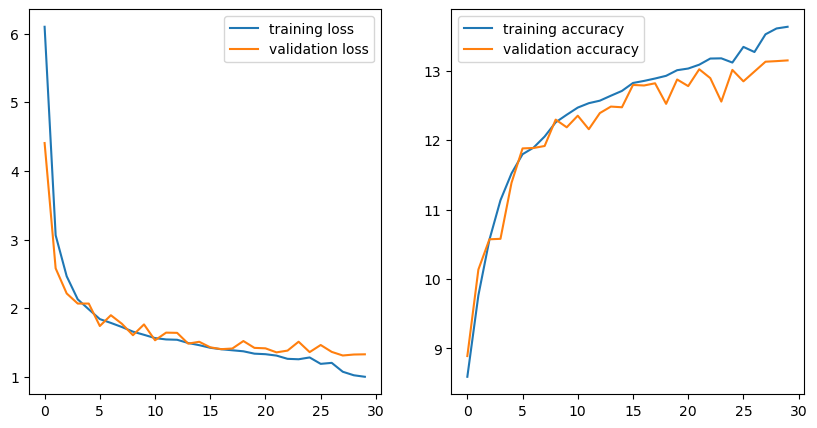

In [35]:
f = plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.plot(train_loss, label='training loss')
plt.plot(valid_loss, label='validation loss')
plt.legend()

plt.subplot(1,2,2)
# f = plt.figure(figsize=(8, 5))
plt.plot(train_acc, label='training accuracy')
plt.plot(valid_acc, label='validation accuracy')
plt.legend()
plt.show()

## LOADING MODEL

In [27]:
#Only load best_model when you train the model
# load_checkpoint(torch.load("/kaggle/working/best_model.pth"), model)
# load_checkpoint(torch.load("/kaggle/working/final_model.pth"), model)

#It is saved model file which was uploaded on kaggle
load_checkpoint(torch.load("/kaggle/input/final-file/Final_model.pth"), model)

#Code to run model in device
# load_checkpoint(torch.load("/kaggle/input/final-file/Final_model.pth"), model)

=> Loading checkpoint


In [28]:
test_real, test_mask = next(iter(val_loader))
print(test_real.shape)
print(type(test_mask))
with torch.no_grad():
    test_real =test_real.to(device)
    test_mask = test_mask.to(device)
    model.eval()
    test_out = model(test_real.float()).to(device)
    
    
    preds_x = torch.softmax(test_out,dim=1)
predicted_mask = torch.argmax(preds_x,dim=1,keepdim=True)
print(predicted_mask.shape)

torch.Size([16, 3, 300, 300])
<class 'torch.Tensor'>
torch.Size([16, 1, 300, 300])


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


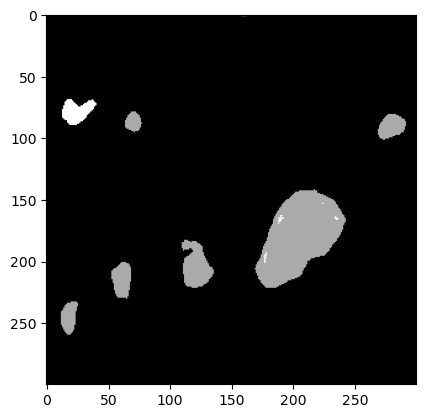

In [29]:
bf = predicted_mask[0].cpu().numpy()
bf = np.squeeze(bf)
plt.imshow(bf,cmap='gray')

torch.Size([3, 300, 300])
torch.Size([300, 300, 3])


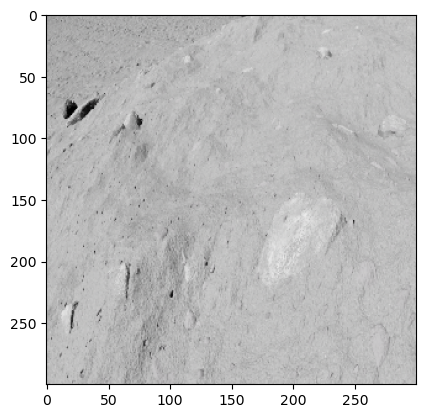

In [30]:
b = test_real[0].cpu()
print(b.shape)
sd=torch.transpose(b,0,1)
# print(sd.shape)
jk=torch.transpose(sd,1,2)
print(jk.shape)
df1=np.float32(jk)
plt.imshow(df1)

<class 'torch.Tensor'>
<class 'torch.Tensor'>


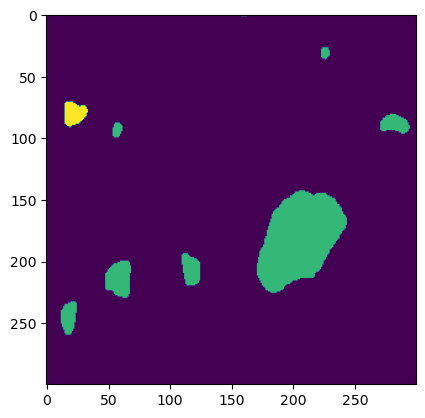

In [31]:
print(type(test_mask))
b = test_mask[0].cpu()
print(type(b))
dfg2 =np.float32(b)
plt.imshow(dfg2)

In [35]:
#IoU Calculation
print(type(predicted_mask))
print(type(dfg2))
def iou_score(predicted_mask,test_mask):
    IoU=0
    intersection = np.logical_and(predicted_mask,test_mask) 
    union = np.logical_or(test_mask,predicted_mask)
    IoU = np.round(np.sum(intersection)/np.sum(union),3) 
    return IoU

iou  = iou_score(bf,dfg2)
print("IoU Score :",iou)

<class 'torch.Tensor'>
<class 'numpy.ndarray'>
IoU Score : 0.751


## INFERENCE 

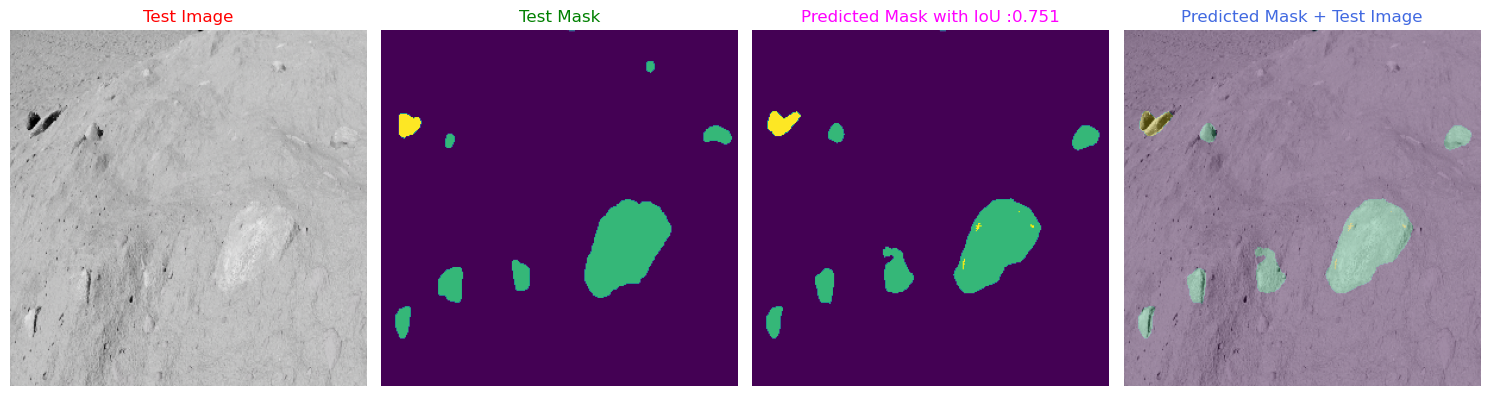

In [36]:

# /kaggle/input/artificial-lunar-rocky-landscape-dataset/real_moon_images/PCAM10.png
# The following data will be used for plotting
plot_data = [[df1, dfg2, bf],
             ['Test Image', 'Test Mask', f'Predicted Mask with IoU :{iou}'],
             ['red', 'green', 'magenta']]

# Adjust the figure for subplot

plt.figure(figsize = (15, 6))
# 4 axes will be ploted in one figure
for i in range(len(plot_data[0])+1):                            # For i = 0 to 3 (inclusive)                   
    if i < 3:                                                   # if i is less than 3
        plt.subplot(1, 4, i+1)                                  # set position on figure
        plt.imshow(plot_data[0][i])                             # plot the respective data 
        plt.title(plot_data[1][i], color = plot_data[2][i])     # add respective title
        plt.axis('off')                                         # turn off the axes values
    else:                                                       # if is is 3
        plt.subplot(1, 4, 4)                                    # plot on the 4th position
        plt.imshow(df1)                                    # test img
        plt.imshow(bf, alpha = 0.3)                 # on top of test img plot predicted mask
        plt.title('Predicted Mask + Test Image', color = 'royalblue') # add title
        plt.axis('off')                                         # turn of the axes values agai

plt.tight_layout()              
plt.show()

## UNKNOWN IMAGE FOR MODEL

torch.Size([350, 350, 3])
torch.Size([1, 1, 350, 350])


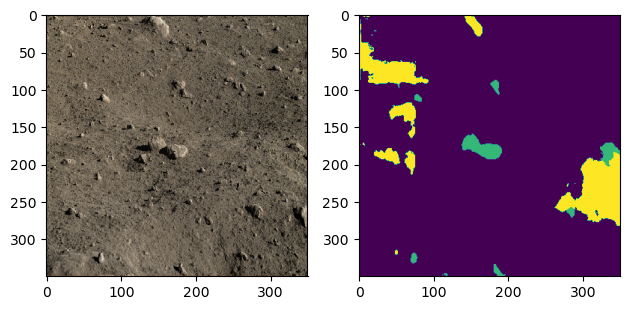

In [37]:
IMG1 =cv.imread('/kaggle/input/artificial-lunar-rocky-landscape-dataset/real_moon_images/PCAM4.png')
IMG3=cv.resize(IMG1,(350,350),interpolation =cv.INTER_NEAREST)
IMG2 = (cv.cvtColor(IMG3,cv.COLOR_RGB2BGR))
IMG= np.array(IMG2, dtype=np.float32)
IMG = IMG/255.0
Torchyman = torch.from_numpy(IMG)
print(Torchyman.shape)
plt.subplot(1,2,1)
plt.imshow(Torchyman)

Torchyman=torch.transpose(Torchyman,1,2)
Torchyman=torch.transpose(Torchyman,0,1)
IMGp=Torchyman.unsqueeze(0)
model.eval()
with torch.no_grad():
    model.eval()
    test_out = model(IMGp.to(device))
    
    
    preds_x = torch.softmax(test_out,dim=1)
predicted_mask = torch.argmax(preds_x,dim=1,keepdim=True)
print(predicted_mask.shape)
plt.axis=0
plt.subplot(1,2,2)
plt.imshow(predicted_mask.cpu().view((350,350,1)))
plt.tight_layout()              
plt.show()


## TESTING PART FROM IMAGES NOT SEEN BY MODEL

In [38]:
# def get_test_img_mask(path):

#Getting images from folder and storing paths in list
test_img_path=[]
test_mask_path=[]
pathx='/kaggle/input/artificial-lunar-rocky-landscape-dataset/real_moon_images/'
list_dir = os.listdir(pathx)
list_dir = sorted(list_dir)
for img_path in list_dir:
    img = img_path.split('/')[-1]
    if img[0] !='g' and img[-4:] != '.csv':
        test_img_path.append(img)
    else:
        test_mask_path.append(img)

#Storing total paths in below lists

test_img = []
test_mask=[]

for image in sorted(test_img_path):
    for mask in sorted(test_mask_path):
        if image[::] == mask[2:]:
            test_img.append(os.path.join(pathx, image))
            test_mask.append(os.path.join(pathx,mask))


## RANDOM IMAGE PREDICTIONS

Enter num in 36 : 1 3 4 5 6 7 8


torch.Size([1, 3, 350, 350])
torch.Size([1, 1, 350, 350])
****************************************************************************************************

torch.Size([1, 3, 350, 350])
torch.Size([1, 1, 350, 350])
****************************************************************************************************

torch.Size([1, 3, 350, 350])
torch.Size([1, 1, 350, 350])
****************************************************************************************************

torch.Size([1, 3, 350, 350])
torch.Size([1, 1, 350, 350])
****************************************************************************************************

torch.Size([1, 3, 350, 350])
torch.Size([1, 1, 350, 350])
****************************************************************************************************

torch.Size([1, 3, 350, 350])
torch.Size([1, 1, 350, 350])
****************************************************************************************************

torch.Size([1, 3, 350, 350])
torch.Size(

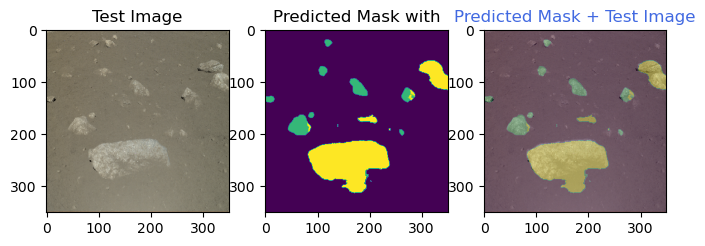

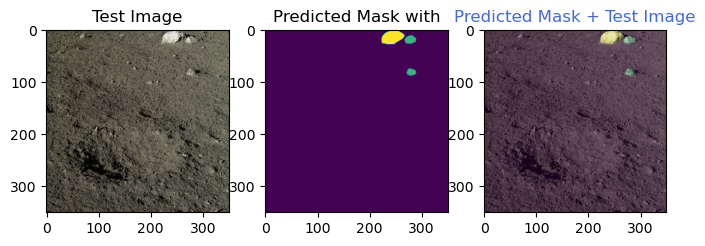

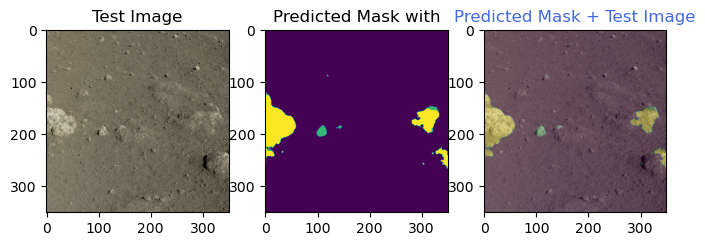

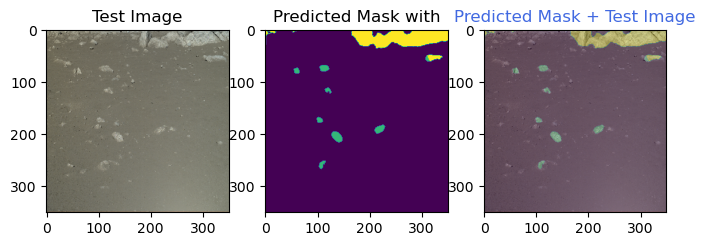

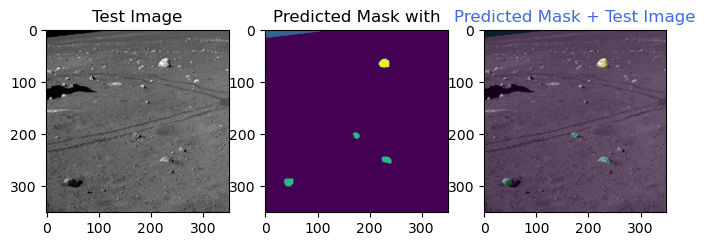

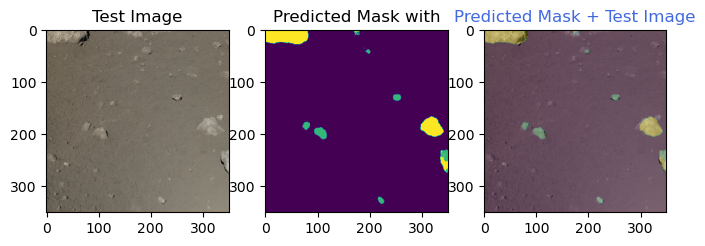

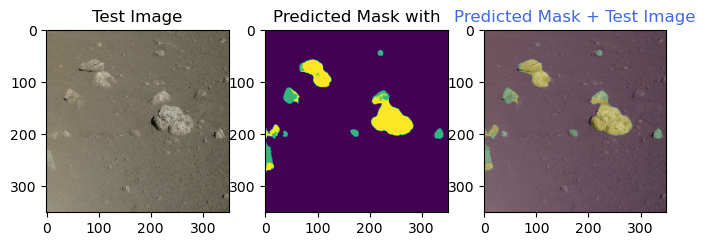

In [41]:
inputx = input(f"Enter num in {len(test_img)} :")
listx = list(map(int,inputx.strip().split()))
# def random_five(model,test_img,num):

for num in listx:

    img_path=test_img[num-1]
    IMG1 =cv.imread(img_path)
    IMG3=cv.resize(IMG1,(350,350),interpolation =cv.INTER_NEAREST)
    IMG2 = (cv.cvtColor(IMG3,cv.COLOR_RGB2BGR))
    IMG= np.array(IMG2, dtype=np.float32)
    IMG = IMG/255.0
    Torchyman = torch.from_numpy(IMG)
    # print(Torchyman.shape)
    plt.figure(figsize=(8,8))
    plt.subplot(1,3,1)
    plt.imshow(Torchyman)
    plt.title("Test Image")
#     plt.axis('off')
    Torchyman2 =Torchyman
    Torchyman2=torch.transpose(Torchyman2,1,2)
    Torchyman2=torch.transpose(Torchyman2,0,1)
    IMGp=Torchyman2.unsqueeze(0)
    print(IMGp.shape)
    model.eval()
    with torch.no_grad():

        test_out = model(IMGp.to(device))
        preds_x = torch.softmax(test_out,dim=1)
    predicted_mask = torch.argmax(preds_x,dim=1,keepdim=True)
    print(predicted_mask.shape)
#     IoU = iou_score(predicted_mask,IMGp)
#     print(IoU)
    plt.subplot(1,3,2)
    plt.imshow(predicted_mask.cpu().view((350,350,1)))
    plt.title("Predicted Mask with")
#     plt.axis('off') 

    plt.subplot(1,3,3)
    plt.imshow(Torchyman.view((350,350,3)))                                  # test img
    plt.imshow(predicted_mask.cpu().view((350,350,1)), alpha = 0.3)                 # on top of test img plot predicted mask
    plt.title('Predicted Mask + Test Image', color = 'royalblue') # add title
    print("*"*100)
    print()
        
# random_five(model,test_img,num)

-----